# Setup PySpark

In [85]:
# Installing Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [86]:
# Setting environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [87]:
# Initializing Spark
import findspark
findspark.init()

In [88]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Loading and Explore the Data

In [89]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import mean, stddev
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')


In [90]:
# Loading the dataset with correct schema
df = spark.read.csv('/content/nyc_taxi_trip_duration.csv', header=True, inferSchema=True)

In [91]:
# schema
print("Schema:")
df.printSchema()

Schema:
root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



In [92]:
print("\nSample data:")
df.show(5)


Sample data:
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id1080784|        2|2016-02-29 16:40:21|2016-02-29 16:47:01|              1|-73.95391845703125| 40.77887344360352|-73.96387481689453| 40.77116394042969|                 N|          400|
|id0889885|        1|2016-03-11 23:35:37|2016-03-11 23:53:57|              2|-73.98831176757811| 40.73174285888672| -73.9947509765625| 40.69493103027344|                 N|         1100|
|id0857912|        2|2016-02-21 17:59:33|2016-02-21

# Data Cleaning and Preprocessing

In [93]:
# Checking for null values
print("Null values count:")
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

Null values count:
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



In [94]:
# Calculating the actual trip duration from timestamps for validation
df = df.withColumn("calculated_duration",
                  (col("dropoff_datetime").cast("long") - col("pickup_datetime").cast("long")))

In [95]:
# Checking if provided duration matches calculated duration
df.select("trip_duration", "calculated_duration").show()

+-------------+-------------------+
|trip_duration|calculated_duration|
+-------------+-------------------+
|          400|               null|
|         1100|               null|
|         1635|               null|
|         1141|               null|
|          848|               null|
|         1455|               null|
|          397|               null|
|         1101|               null|
|         1886|               null|
|         1429|               null|
|          527|               null|
|          911|               null|
|          311|               null|
|         1070|               null|
|          661|               null|
|        86164|               null|
|          891|               null|
|         1547|               null|
|          717|               null|
|         1375|               null|
+-------------+-------------------+
only showing top 20 rows



In [96]:
# Calculating distance using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Converting degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

In [97]:
# Register the UDF
haversine_udf = udf(haversine, DoubleType())


In [98]:
from pyspark.sql.functions import radians, sin, cos, sqrt, atan2, col, hour, dayofmonth, month, dayofweek, to_timestamp

# Converting datetime columns to datetime type
df = df.withColumn("pickup_datetime", to_timestamp("pickup_datetime"))
df = df.withColumn("dropoff_datetime", to_timestamp("dropoff_datetime"))

# Calculating distance using Spark SQL functions (Haversine formula)
R = 6371  # Radius of Earth in kilometers

lat1_rad = radians(col("pickup_latitude"))
lon1_rad = radians(col("pickup_longitude"))
lat2_rad = radians(col("dropoff_latitude"))
lon2_rad = radians(col("dropoff_longitude"))

dlon = lon2_rad - lon1_rad
dlat = lat2_rad - lat1_rad

a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

df = df.withColumn("distance", distance)

# Extracting time features
df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))
df = df.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))
df = df.withColumn("pickup_month", month(col("pickup_datetime")))
df = df.withColumn("pickup_day_of_week", dayofweek(col("pickup_datetime")))

In [99]:
# Showing the enhanced dataframe
df.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-------------------+------------------+-----------+----------+------------+------------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|calculated_duration|          distance|pickup_hour|pickup_day|pickup_month|pickup_day_of_week|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-------------------+------------------+-----------+----------+------------+------------------+
|id1080784|        2|2016-02-29 16:40:21|2016-02-29 16:47:01|              1|-73.95391845703125| 40.77887344360352|-73.96387481689453| 40.77116394042969|    

# Exploratory Data Analysis (EDA)

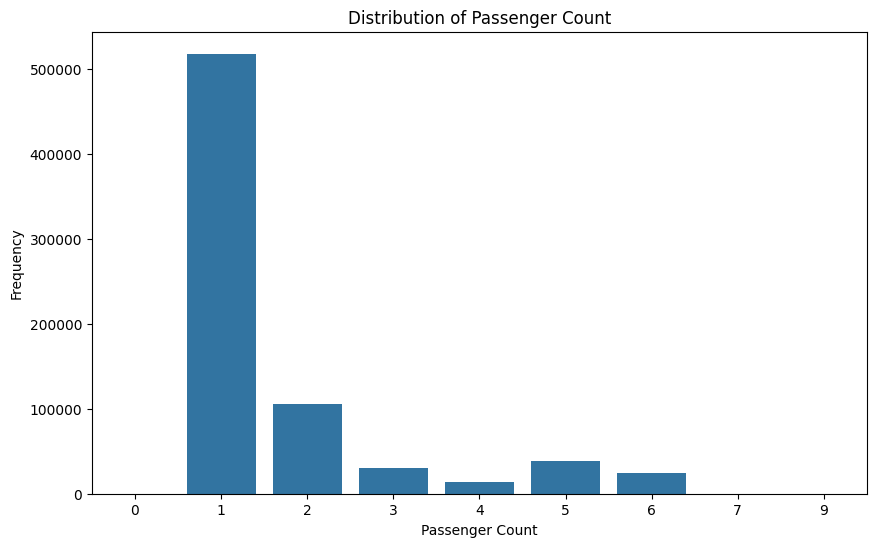

In [100]:
passenger_count_counts = pdf_filtered['passenger_count'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=passenger_count_counts.index, y=passenger_count_counts.values)
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')
plt.show()

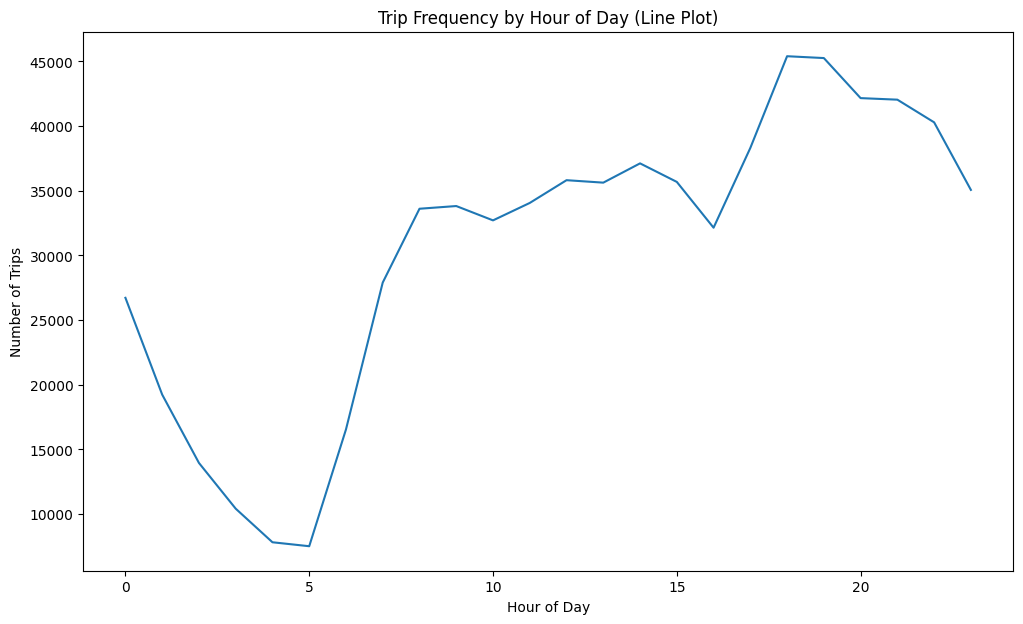

In [101]:
trip_count_by_hour = pdf_filtered.groupby('pickup_hour').size()


plt.figure(figsize=(12, 7))
sns.lineplot(x=trip_count_by_hour.index, y=trip_count_by_hour.values)
plt.title('Trip Frequency by Hour of Day (Line Plot)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

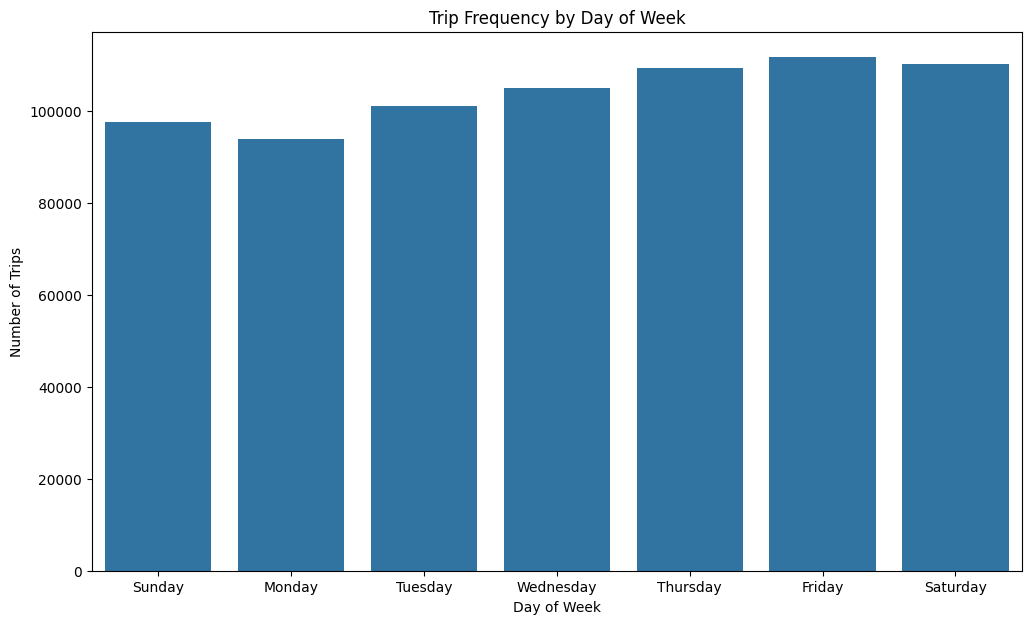

In [102]:
trip_count_by_day_of_week = pdf_filtered.groupby('pickup_day_of_week').size()

# Map numerical day of the week to names
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
trip_count_by_day_of_week = trip_count_by_day_of_week.rename(index=day_names)

plt.figure(figsize=(12, 7))
sns.barplot(x=trip_count_by_day_of_week.index, y=trip_count_by_day_of_week.values, order=day_names.values())
plt.title('Trip Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.show()

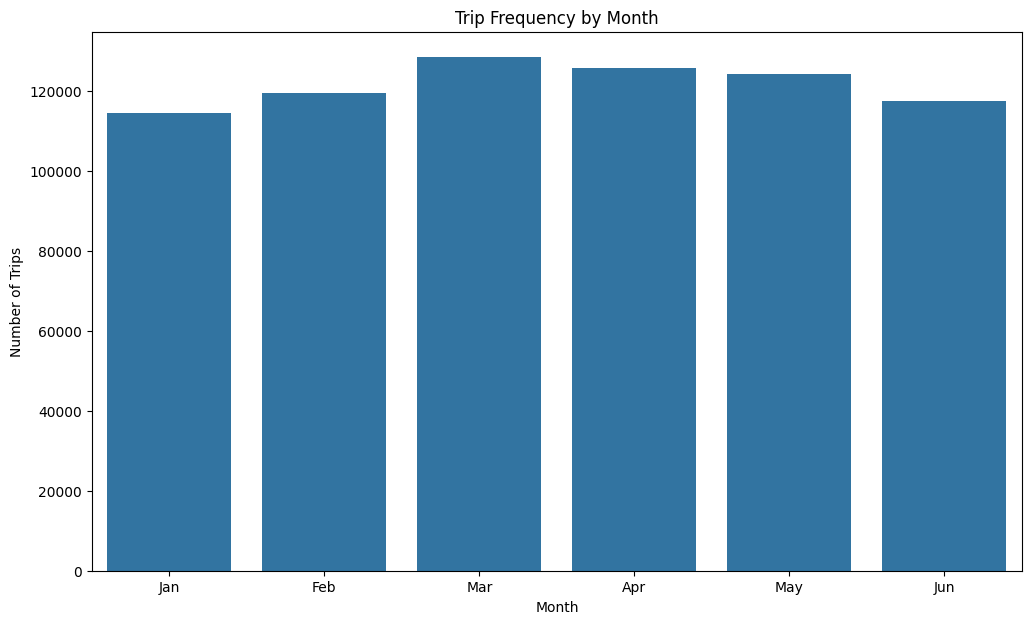

In [103]:
trip_count_by_month = pdf_filtered.groupby('pickup_month').size()

# Map numerical month to names
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun'}
trip_count_by_month = trip_count_by_month.rename(index=month_names)

plt.figure(figsize=(12, 7))
sns.barplot(x=trip_count_by_month.index, y=trip_count_by_month.values, order=month_names.values())
plt.title('Trip Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

# Outlier Removal

In [104]:
# Calculating mean and stddev
stats = df.select(
    mean("trip_duration").alias("mean"),
    stddev("trip_duration").alias("stddev")
).collect()

mean_val = stats[0]["mean"]
stddev_val = stats[0]["stddev"]

In [105]:
# Defining outlier thresholds (3 standard deviations)
lower_bound = mean_val - 3 * stddev_val
upper_bound = mean_val + 3 * stddev_val

print(f"Mean: {mean_val}, StdDev: {stddev_val}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Mean: 952.2291333594764, StdDev: 3864.6261972812454
Lower bound: -10641.649458484259, Upper bound: 12546.107725203212


In [106]:
# Filter outliers
df_clean = df.filter(
    (col("trip_duration") > lower_bound) &
    (col("trip_duration") < upper_bound)
)

print(f"Original count: {df.count()}, Cleaned count: {df_clean.count()}")

Original count: 729322, Cleaned count: 728302


# Feature Engineering and Model Preparation

In [107]:
# Preparing features
feature_cols = ['vendor_id', 'passenger_count', 'distance',
                'pickup_hour', 'pickup_day_of_week']

# Assemble features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [108]:
# Splitting data into train and test sets
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Training data count: 582533
Test data count: 145769


# Model Building - Linear Regression

In [109]:
# Creating Linear Regression model
lr = LinearRegression(
    featuresCol="features",
    labelCol="trip_duration",
    predictionCol="prediction",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)

In [110]:
# Creating pipeline
pipeline_lr = Pipeline(stages=[assembler, lr])

In [111]:
# Training model
model_lr = pipeline_lr.fit(train_data)

In [112]:
# Making predictions
predictions_lr = model_lr.transform(test_data)

In [113]:
# Evaluating model
evaluator = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="rmse"
)

In [84]:
rmse_lr = evaluator.evaluate(predictions_lr)
print(f"Root Mean Squared Error (RMSE) for Linear Regression: {rmse_lr}")

Root Mean Squared Error (RMSE) for Linear Regression: 439.1897055156266


In [114]:
# Showing some predictions
predictions_lr.select("trip_duration", "prediction", "distance").show(5)

# Additional metrics
evaluator_r2 = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="r2"
)

r2_lr = evaluator_r2.evaluate(predictions_lr)
print(f"R-squared for Linear Regression: {r2_lr}")

+-------------+------------------+------------------+
|trip_duration|        prediction|          distance|
+-------------+------------------+------------------+
|          378| 605.9167854676967|1.2172705607602117|
|         1162|1062.5498340351357| 5.100728052671935|
|          987|  801.625505333115| 3.537244686915253|
|         1217| 1445.893122699162| 9.914421941706403|
|         1861|2580.8258528848896|20.557242060081947|
+-------------+------------------+------------------+
only showing top 5 rows

R-squared for Linear Regression: 0.5610778470035863


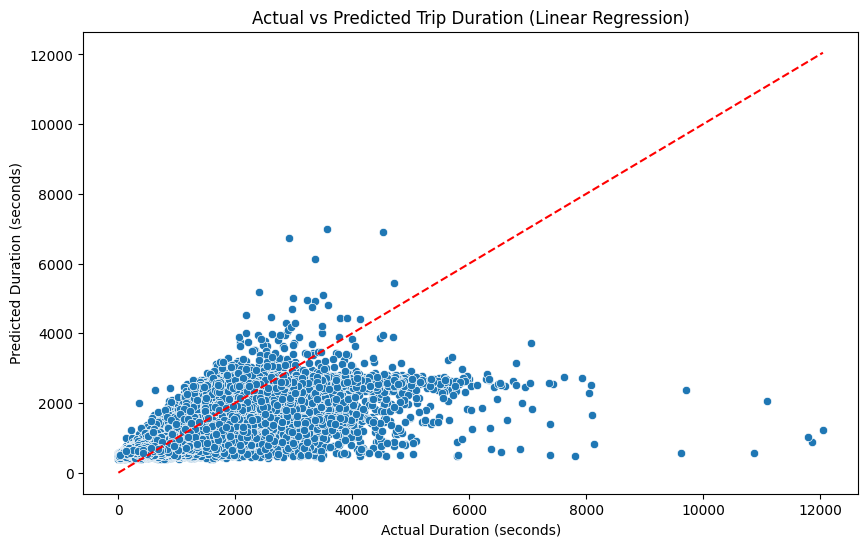

In [115]:
# Plot actual vs predicted
pdf_lr = predictions_lr.select("trip_duration", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration', y='prediction', data=pdf_lr)
plt.plot([pdf_lr['trip_duration'].min(), pdf_lr['trip_duration'].max()],
         [pdf_lr['trip_duration'].min(), pdf_lr['trip_duration'].max()],
         'r--')
plt.title('Actual vs Predicted Trip Duration (Linear Regression)')
plt.xlabel('Actual Duration (seconds)')
plt.ylabel('Predicted Duration (seconds)')
plt.show()

# Model Building - Random Forest Regression

In [116]:
# Creating Random Forest model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="trip_duration",
    predictionCol="prediction",
    numTrees=20,
    maxDepth=5,
    seed=42
)

In [117]:
# Creating pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])


In [118]:
# Training model
model_rf = pipeline_rf.fit(train_data)


In [119]:
# Making predictions
predictions_rf = model_rf.transform(test_data)

In [120]:
# Evaluating model
rmse_rf = evaluator.evaluate(predictions_rf)
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf}")

r2_rf = evaluator_r2.evaluate(predictions_rf)
print(f"R-squared for Random Forest: {r2_rf}")

Root Mean Squared Error (RMSE) for Random Forest: 410.7376393204195
R-squared for Random Forest: 0.6161052237501834


In [121]:
# Showing some predictions
predictions_rf.select("trip_duration", "prediction", "distance").show(5)

+-------------+------------------+------------------+
|trip_duration|        prediction|          distance|
+-------------+------------------+------------------+
|          378| 605.4159659436381|1.2172705607602117|
|         1162|1262.3341774991359| 5.100728052671935|
|          987| 800.0791398829471| 3.537244686915253|
|         1217|1523.2008050057725| 9.914421941706403|
|         1861| 1859.187517163801|20.557242060081947|
+-------------+------------------+------------------+
only showing top 5 rows



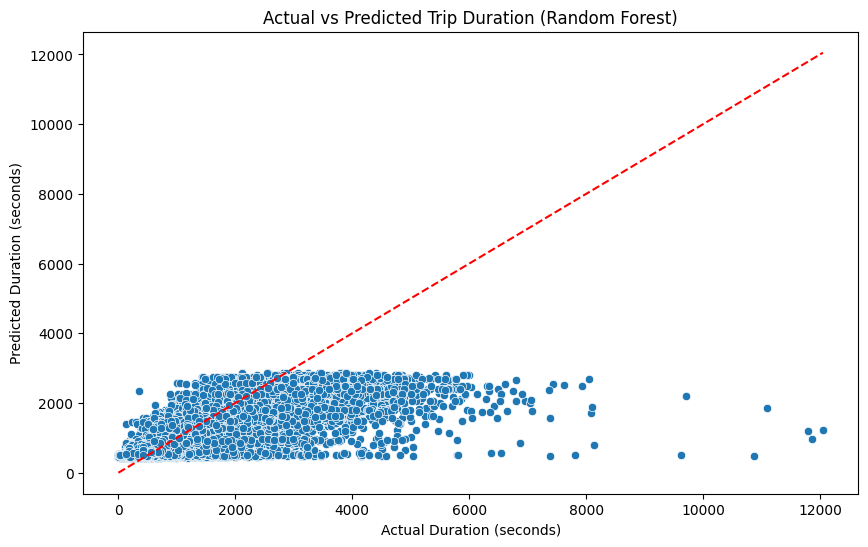

In [122]:
# Plot actual vs predicted
pdf_rf = predictions_rf.select("trip_duration", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_duration', y='prediction', data=pdf_rf)
plt.plot([pdf_rf['trip_duration'].min(), pdf_rf['trip_duration'].max()],
         [pdf_rf['trip_duration'].min(), pdf_rf['trip_duration'].max()],
         'r--')
plt.title('Actual vs Predicted Trip Duration (Random Forest)')
plt.xlabel('Actual Duration (seconds)')
plt.ylabel('Predicted Duration (seconds)')
plt.show()

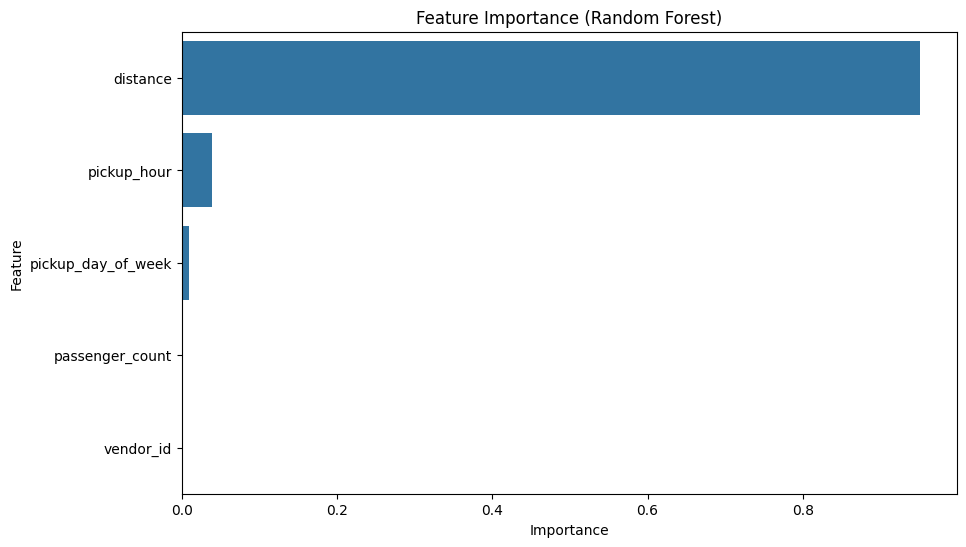

In [123]:
# Feature importance
rf_model = model_rf.stages[-1]
importances = rf_model.featureImportances.toArray()
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()

# Model Comparison and Conclusion

In [124]:
# Comparing both models
results = {
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf],
    'R-squared': [r2_lr, r2_rf]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)


Model Comparison:
               Model        RMSE  R-squared
0  Linear Regression  439.189706   0.561078
1      Random Forest  410.737639   0.616105


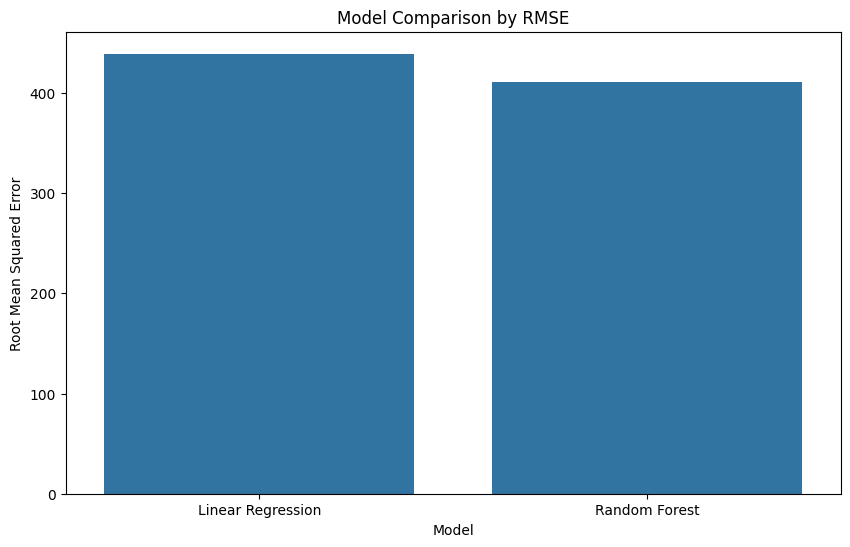

In [125]:
# Visual comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('Model Comparison by RMSE')
plt.ylabel('Root Mean Squared Error')
plt.show()

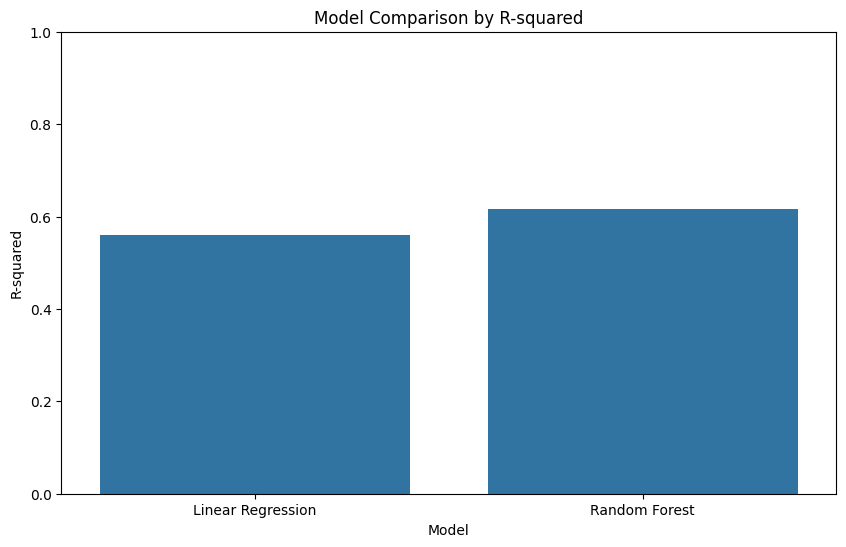

In [126]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R-squared', data=results_df)
plt.title('Model Comparison by R-squared')
plt.ylabel('R-squared')
plt.ylim(0, 1)
plt.show()